# Twitter Stock Sentiment Analysis


## What is Sentiment Analysis

Sentiment analysis is a strategy that is usually associated with social media. This strategy is useful for determining the general public's sentiment towards something (e.g. a company, stocks, crypto currencies, etc) and is ultimately a classification problem. The possible classifications are generally positive, negative and neutral, but can include specific feelings/emotions like anger, happy, sad, etc. When analyzing the things people say, this sort of strategy allows us to determine how people are feeling towards the company/stock/etc in question. That then allows us to make decisions in response to how people are feeling. A company might use this strategy to determine how well a past decision has been viewed by the general public and then use that information to learn from their victories or mistakes. A stock broker might also use a tool that utilizes sentiment analysis to help them decide if they should sell or buy certain stocks based on what other people might do with those stocks.

## Stocks on Social Media

The general public talks about stocks on a daily basis and the value of each stock is greatly affected by people selling or buying their shares. Each stock has a particular identifier (e.g. $NVDA) that is usually  referenced in these discussions, which makes it possible to accurately determine which specific stock people talking about. These discussions also convey a certain sentiment of how these people feel towards the stock at the time of the posts on social media.

A stock broker probably watches the value charts for stocks and the announcements made by the companies, but the general sentiment towards the companies is another important aspect for allowing a broker to accurately predict the movement of a stock's value. Stock brokers at the very least have some sort of news feed for helping them predict future stock values. It's unclear whether social media is the best source of information since the experts might be withholding their views while the uninformed masses might be more vocal about their opinions. However, it's probably a good idea to listen to normal people because they can definitely affect the stock market if they all sell or buy at the same time. In the end, a wide array of sources on stocks is probably necessary to make accurate decisions, but stock sentiment analysis on social media could be one of the valuable sources of information.

## Data Collection

There are various sources of social media discussions out there: Twitter, Reddit, Facebook, etc. These social media sites usually have an API that allows us to write scripts for retrieving relevant discussions. These relevant discussions should at the very least contain a stock identifier (e.g. $NVDA) so that it's possible to associate a sentiment with a stock.

In addition to the social media discussions, it is also useful to have access to the stock time-series values to check the accuracy of the price change predictions.

Dataset: https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data
Model: https://huggingface.co/bert-base-uncased

In [26]:
import re
import os
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel, TFBertModel
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoModel, AutoTokenizer 

import torch
from torch import cuda
from tqdm.notebook import tqdm
#device = 'cuda' if cuda.is_available() else 'cpu'
device = 'cpu'

import reticker

In [27]:
df = pd.read_excel('tweets_labelled_09042020_16072020.xlsx', engine='openpyxl', parse_dates=['created_at'])
df.drop(columns=df.columns.difference(['id', 'created_at', 'text', 'sentiment']), inplace=True)
df.set_index('id')
#df.fillna({'sentiment':'neutral'}, inplace=True)
df = df.dropna()
print(df)

print()
print('Unique Sentiment Values:')
print(df['sentiment'].unique())

          id                created_at  \
0      77522 2020-04-15 01:03:46+00:00   
1     661634 2020-06-25 06:20:06+00:00   
2     413231 2020-06-04 15:41:45+00:00   
3     760262 2020-07-03 19:39:35+00:00   
4     830153 2020-07-09 14:39:14+00:00   
...      ...                       ...   
1295   75519 2020-04-15 06:00:10+00:00   
1296  739234 2020-07-01 11:29:10+00:00   
1297  254379 2020-04-29 02:21:50+00:00   
1298  580441 2020-06-19 17:56:57+00:00   
1299  625070 2020-06-23 15:47:11+00:00   

                                                   text sentiment  
0     RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...  positive  
1     #SriLanka surcharge on fuel removed!\n⛽📉\nThe ...  negative  
2     Net issuance increases to fund fiscal programs...  positive  
3     RT @bentboolean: How much of Amazon's traffic ...  positive  
4     $AMD Ryzen 4000 desktop CPUs looking ‘great’ a...  positive  
...                                                 ...       ...  
1295  #stocks back 

## Utilities

Below are helpful utilities for loading datasets, making a classifier, training/testing the classifier and analyzing the confusion matrix results.

In [28]:
class MultiLabelDataset(torch.utils.data.Dataset):

    def __init__(self, text, labels, dates, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.dates = dates
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': self.targets[index].clone().detach(),
            'date': self.dates[index].clone().detach()
        }
    
class BERTClassifier(torch.nn.Module):
    def __init__(self, NUM_OUT, model):
        super(BERTClassifier, self).__init__()
                   
        self.l1 = model
        self.pre_classifier = torch.nn.Linear(768, 512)
        self.begin_dropout = torch.nn.Dropout(0.2)
        self.hidden_layer1 = torch.nn.Linear(512, 256)
        self.hidden_layer2 = torch.nn.Linear(256, 128)
        self.classifier = torch.nn.Linear(128, NUM_OUT)
        self.end_dropout = torch.nn.Dropout(0.2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = self.begin_dropout(pooler)
        pooler = self.hidden_layer1(pooler)
        pooler = self.hidden_layer2(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.end_dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output
    
def date_to_epoch_millis(date):
    return date.timestamp() * 1000

def epoch_millis_to_date(millis):
    return datetime.fromtimestamp(millis / 1000.0).date()
    
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train_model(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validate_model(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    fin_dates=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            dates = data['date'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
            fin_dates.extend(dates)
    return torch.stack(fin_outputs), torch.stack(fin_targets), torch.stack(fin_dates)

In [29]:
from pprint import pprint
from sklearn.metrics import confusion_matrix

def confusion_matrix_accuracy(matrix):
    '''
    Returns the percent accuracy based on the provided confusion matrix.
    The value will be between 0 and 100.
    '''
    correct_total = 0
    total = 0
    for index, row in enumerate(matrix):
        total += sum(row)
        correct_total += row[index]
    return correct_total / total * 100

def confusion_matrix_invalid_predictions(matrix, labels):
    '''
    Returns a list of tuples. Each tuple will represent an invalid prediction with a size of three.
    The first value will be the expected truth, the second will be the failed prediction and the third will
    be the number of these failed predictions.
    '''
    invalid_predictions = []
    for i, row in enumerate(matrix):
        for j, column in enumerate(row):
            # We only are interested in the incorrect predictions!
            if i != j and column > 0:
                invalid_predictions.append((labels[i], labels[j], column))
    return invalid_predictions

def print_invalid_predictions(matrix, labels):
    invalid_predictions = confusion_matrix_invalid_predictions(matrix, labels)
    
    print('Top 6 Invalid Predictions (truth, prediction, count):')
    pprint(sorted(invalid_predictions, key = lambda prediction: prediction[2], reverse=True)[:6])

def confusion_matrix_valid_predictions(matrix, labels):
    '''
    Returns a list of tuples. Each tuple will represent a valid prediction with a size of two.
    The first value will be the correct prediction, the second will be the number of these correct predictions.
    '''
    valid_predictions = []
    for i, row in enumerate(matrix):
        for j, column in enumerate(row):
            # We only are interested in the correct predictions!
            if i == j and column > 0:
                valid_predictions.append((labels[i], column))
    return valid_predictions

def print_valid_predictions(matrix, labels):
    valid_predictions = confusion_matrix_valid_predictions(matrix, labels)
    
    print('Top 6 Valid Predictions (prediction, count):')
    pprint(sorted(valid_predictions, key = lambda prediction: prediction[1], reverse=True)[:6])

## Labels

Before training our model we're going to add labels to our dataset that are the integer representations of the sentiment labels.

In [30]:
sentiment_labels = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# For convenience later, this gets the title of the labels in the order of the labels.
label_titles = ['negative', 'neutral', 'positive']

def sentiment_label(row):
    return sentiment_labels[row['sentiment']]

df['label'] = df.apply(sentiment_label, axis=1)
df

,id,created_at,text,sentiment,label
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,2
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,0
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive,2
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive,2
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,2
...,...,...,...,...,...
1295,75519,2020-04-15 06:00:10+00:00,#stocks back from the recovery room: https://t...,positive,2
1296,739234,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,positive,2
1297,254379,2020-04-29 02:21:50+00:00,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,neutral,1
1298,580441,2020-06-19 17:56:57+00:00,$AAPL $QQQ Top may now be in. https://t.co/iNK...,positive,2


## Training/Test Dataset

We're going to be training a model with labeled tweets and later using that model for predicting sentiment for unlabeled tweets. Due to that we don't actually need a test dataset here, but we create a small test dataset just to check the accuracy of our model on the labeled tweets.

In [31]:
train, test = train_test_split(df, test_size=0.05)
print('Training Data Size: {}'.format(len(train)))
print('\nTest Data Size: {}'.format(len(test)))

Training Data Size: 1235

Test Data Size: 65


## Training the Model

Below we're going to set up our dataset loader and then we go through the training process for the model over several epochs. The small test dataset will also be used to check the model's accuracy as it goes through the training process.

In [32]:
MAX_LEN = 512
BATCH_SIZE = 32
EPOCHS = 7
NUM_OUT = len(sentiment_labels)
LEARNING_RATE = 2e-06
#MODEL_ID = 'vinai/bertweet-base'
#MODEL_ID = 'rabindralamsal/BERTsent'
MODEL_ID = 'bert-base-uncased'
#MODEL_ID = 'jirmauritz/bert-multilingual-emoji'
#MODEL_ID = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

training_data = MultiLabelDataset(
    train['text'].to_numpy(),
    torch.from_numpy(train['label'].to_numpy()),
    torch.from_numpy(train['created_at'].map(date_to_epoch_millis).to_numpy()),
    tokenizer,
    MAX_LEN
)
test_data = MultiLabelDataset(
    test['text'].to_numpy(),
    torch.from_numpy(test['label'].to_numpy()),
    torch.from_numpy(test['created_at'].map(date_to_epoch_millis).to_numpy()),
    tokenizer,
    MAX_LEN
)

train_params = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 0, Loss:  1.069422960281372


  0%|          | 0/3 [00:00<?, ?it/s]

Prediction Accuracy: 38.46153846153847
Top 6 Invalid Predictions (truth, prediction, count):
[('neutral', 'positive', 23), ('negative', 'positive', 17)]

Top 6 Valid Predictions (prediction, count):
[('positive', 25)]



  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 1, Loss:  1.116603970527649


  0%|          | 0/3 [00:00<?, ?it/s]

Prediction Accuracy: 38.46153846153847
Top 6 Invalid Predictions (truth, prediction, count):
[('neutral', 'positive', 23), ('negative', 'positive', 17)]

Top 6 Valid Predictions (prediction, count):
[('positive', 25)]



  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 2, Loss:  1.1085660457611084


  0%|          | 0/3 [00:00<?, ?it/s]

Prediction Accuracy: 38.46153846153847
Top 6 Invalid Predictions (truth, prediction, count):
[('neutral', 'positive', 23), ('negative', 'positive', 17)]

Top 6 Valid Predictions (prediction, count):
[('positive', 25)]



  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 3, Loss:  1.10792076587677


  0%|          | 0/3 [00:00<?, ?it/s]

Prediction Accuracy: 38.46153846153847
Top 6 Invalid Predictions (truth, prediction, count):
[('neutral', 'positive', 23), ('negative', 'positive', 17)]

Top 6 Valid Predictions (prediction, count):
[('positive', 25)]



  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 4, Loss:  1.0850600004196167


  0%|          | 0/3 [00:00<?, ?it/s]

Prediction Accuracy: 41.53846153846154
Top 6 Invalid Predictions (truth, prediction, count):
[('neutral', 'positive', 21),
 ('negative', 'positive', 16),
 ('negative', 'neutral', 1)]

Top 6 Valid Predictions (prediction, count):
[('positive', 25), ('neutral', 2)]



  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 5, Loss:  1.0919219255447388


  0%|          | 0/3 [00:00<?, ?it/s]

Prediction Accuracy: 43.07692307692308
Top 6 Invalid Predictions (truth, prediction, count):
[('neutral', 'positive', 18),
 ('negative', 'positive', 15),
 ('negative', 'neutral', 2),
 ('positive', 'neutral', 2)]

Top 6 Valid Predictions (prediction, count):
[('positive', 23), ('neutral', 5)]



  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 6, Loss:  1.010249376296997


  0%|          | 0/3 [00:00<?, ?it/s]

Prediction Accuracy: 47.69230769230769
Top 6 Invalid Predictions (truth, prediction, count):
[('neutral', 'positive', 14),
 ('negative', 'positive', 13),
 ('negative', 'neutral', 3),
 ('positive', 'neutral', 3),
 ('positive', 'negative', 1)]

Top 6 Valid Predictions (prediction, count):
[('positive', 21), ('neutral', 9), ('negative', 1)]



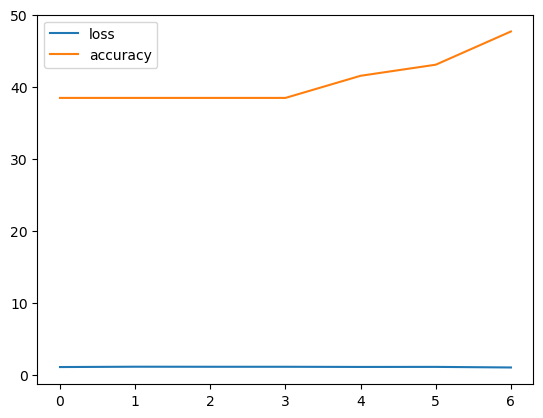

In [33]:
model = BERTClassifier(NUM_OUT, AutoModel.from_pretrained(MODEL_ID))
model.to(device)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
loss_results = []
accuracy_results = []
for epoch in range(EPOCHS):
    loss = train_model(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')
    loss_results.append(loss.item())
    guess, targs, dates = validate_model(model, testing_loader)
    guesses = torch.max(guess, dim=1)
    
    cmatrix = confusion_matrix(targs, guesses.indices)
    accuracy = confusion_matrix_accuracy(cmatrix)
    print('Prediction Accuracy: {}'.format(accuracy))
    accuracy_results.append(accuracy)

    print_invalid_predictions(cmatrix, label_titles)
    print()

    print_valid_predictions(cmatrix, label_titles)
    print()

pd.DataFrame({'loss': loss_results, 'accuracy': accuracy_results}).plot()
plt.show()

## Final Unlabeled Dataset

Here we load the unlabeled tweet dataset and we're going to be filtering it to only the tweets that contain the 'SPY' ticker. By reducing our dataset to a single stock, we can have an easier time of examining the results later on.

In [34]:
test_df = pd.read_csv('tweets_remaining_09042020_16072020.csv', delimiter=';', parse_dates=['created_at'])
test_df.set_index('id')

ticket_extractor = reticker.TickerExtractor()

def tickers(row):
    #return re.findall(r'[$](([A-Za-z]{1,5})(-[A-Za-z]{1,2})?)', row['full_text'])
    return ticket_extractor.extract(row['full_text'])

test_df['tickers'] = test_df.apply(tickers, axis=1)
test_df

,id,created_at,full_text,tickers
0,1,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...,[SPX]
1,2,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...,"[SPX, SPY]"
2,3,2020-04-09 23:58:52+00:00,RT @KimbleCharting: Silver/Gold indicator crea...,[RT]
3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,[MSFT]
4,5,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...,"[RT, GILD, MO]"
...,...,...,...,...
923668,938668,2020-07-16 00:00:25+00:00,RT @MadMraket: We tend to spend lot of time in...,"[RT, BIG, AAPL, MSFT, NFLX, AMZN]"
923669,938669,2020-07-16 00:00:23+00:00,You \n\n$SPX $SPY #ES_F,"[SPX, SPY]"
923670,938670,2020-07-16 00:00:23+00:00,"$KO Coca-Cola #Options #maxpain Chart, Open In...","[KO, UOA]"
923671,938671,2020-07-16 00:00:06+00:00,Here's a dividends watchlist \nfor the 01/04/0...,"[T, BMO, ABBV, VZ, JPM]"


In [35]:
tickers = test_df['tickers'].explode().unique()
print('Total Ticker Count: {}'.format(len(tickers)))

Total Ticker Count: 25969


In [36]:
spy_test_df = test_df[test_df['tickers'].apply(lambda x: 'SPY' in x and len(x) == 1)].copy()
spy_test_df.set_index('id')

,created_at,full_text,tickers
id,,,
228,2020-04-09 23:20:58+00:00,Me and my team we be making that bank roll aft...,[SPY]
1529,2020-04-09 20:46:30+00:00,"Yes, this seems rational. #stocks $spy #dontfi...",[SPY]
1784,2020-04-09 20:23:19+00:00,Let's hope the $spy doesn't do this next week ...,[SPY]
2227,2020-04-09 19:57:48+00:00,Today's #daytrade #Onegoodtrade\n#daytrading ...,[SPY]
2838,2020-04-09 19:11:41+00:00,Another day another gain +5k here in min me an...,[SPY]
...,...,...,...
932707,2020-07-16 13:32:25+00:00,#Bookmap https://t.co/h976yKShMv \n\nmarket co...,[SPY]
933234,2020-07-16 13:05:24+00:00,$SPY slight gap down. Will need price push wi...,[SPY]
933377,2020-07-16 12:59:29+00:00,"Good morning. As mentioned yesterday, we are h...",[SPY]


In [37]:
from datetime import datetime, timedelta

min_timestamp = spy_test_df['created_at'].min().date() + timedelta(days=-1)
max_timestamp = spy_test_df['created_at'].max().date() + timedelta(days=7)

print('Date Range for Test Data: {} - {}'.format(min_timestamp, max_timestamp))

Date Range for Test Data: 2020-04-08 - 2020-07-23


## SPY Stock Data

Since we have unlabeled tweets, we need the SPY stock price information for the same time period as the tweets we're predicting sentiment for. This stock information will be used to determine if our sentiment results are accurate. We classify the unlabeled tweets' expected sentiments based on the next day of stock information after the tweet. If the price change between open and close on that day is positive then the sentiment should be positive and if it is negative the sentiment should be negative.

In [38]:
from polygon import RESTClient
from dotenv import load_dotenv
load_dotenv()

client = RESTClient(api_key=os.environ.get('POLYGON_KEY'))

aggs = client.list_aggs(ticker='SPY', multiplier=1, timespan="day", from_=min_timestamp.strftime('%Y-%m-%d'), to=max_timestamp.strftime('%Y-%m-%d'), limit=50000)

In [39]:
data = []
for agg in aggs:
    date = datetime.fromtimestamp(agg.timestamp / 1000.0).date()
    data.append({'open': agg.open, 'close': agg.close, 'date': date})

spy_df = pd.DataFrame(data)

In [40]:
def expected_prediction(row):
    '''
    Uses the date of the tweet and the stock ticker data to determine the next day's price movement so that we can
    validate our sentiment analysis predictions against the real stock prices.
    It's possible that a tweet is made on a weekend, so the next available stock data will be on a Monday.
    '''
    # The start_date and end_date range will be used to find the next day after the tweet that has stock information.
    # A two week range is probably unnecessary, but it assures us that we will be able to find some stock information.
    start_date = row['created_at'].date() + timedelta(days=1)
    end_date = start_date + timedelta(days=14)
    result = spy_df.query('date >= @start_date and date <= @end_date').head(1)
    
    label = sentiment_labels['neutral']
    if result is not None:
        price_delta = result['close'].item() - result['open'].item()
        if (1 < price_delta):
            label = sentiment_labels['positive']
        elif (price_delta < -1):
            label = sentiment_labels['negative']
    return label

spy_test_df['label'] = spy_test_df.apply(expected_prediction, axis=1)

## Testing Unlabeled Datset

At this point we know what the expected sentiment should be for the SPY related tweets based on the next day's stock price movement. Therefore we use the previously trained model to predict the sentiment for our unlabeled tweets and then we verify the predicted sentiment against the expected sentiment.

In [41]:
final_test_data = MultiLabelDataset(
    spy_test_df['full_text'].to_numpy(),
    torch.from_numpy(spy_test_df['label'].to_numpy()),
    spy_test_df['created_at'].map(date_to_epoch_millis).to_numpy(),
    tokenizer,
    MAX_LEN
)

final_test_params = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}    

final_testing_loader = torch.utils.data.DataLoader(final_test_data, **test_params)

guess, targs, dates = validate_model(model, testing_loader)
guesses = torch.max(guess, dim=1)
    
cmatrix = confusion_matrix(targs, guesses.indices)
accuracy = confusion_matrix_accuracy(cmatrix)
print('Prediction Accuracy: {}'.format(accuracy))

print_invalid_predictions(cmatrix, label_titles)
print()

print_valid_predictions(cmatrix, label_titles)
print()

  0%|          | 0/3 [00:00<?, ?it/s]

Prediction Accuracy: 47.69230769230769
Top 6 Invalid Predictions (truth, prediction, count):
[('neutral', 'positive', 14),
 ('negative', 'positive', 13),
 ('negative', 'neutral', 3),
 ('positive', 'neutral', 3),
 ('positive', 'negative', 1)]

Top 6 Valid Predictions (prediction, count):
[('positive', 21), ('neutral', 9), ('negative', 1)]



## Analyzing the Results

We've run our predictions on the unlabeled tweet dataset at this point and we know what the expected sentiment values should have been. So we put that information into its own dataframe. Then we graph both the SPY price movements between our tweet date range as well as the predicted/expected sentiments across the same date range. Due to both of these graphs being over the same date range we can easily determine what the overall price movement has been outside of the one day of price movement that the expected sentiment is based on.

In [42]:
predictions, targets, prediction_dates = zip(*sorted(
    zip(guesses.indices.tolist(), targs.tolist(), map(epoch_millis_to_date, dates.tolist())), key=lambda x: x[2]
))

prediction_df = pd.DataFrame({
    'prediction': predictions,
    'target': targs,
    'date': prediction_dates
})
prediction_df

,prediction,target,date
0,1,2,2020-04-09
1,2,0,2020-04-09
2,2,1,2020-04-09
3,2,1,2020-04-13
4,2,0,2020-04-14
...,...,...,...
60,2,1,2020-07-13
61,1,2,2020-07-13
62,2,1,2020-07-15
63,2,0,2020-07-16


C:\Users\Cake\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cake\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cake\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cake\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

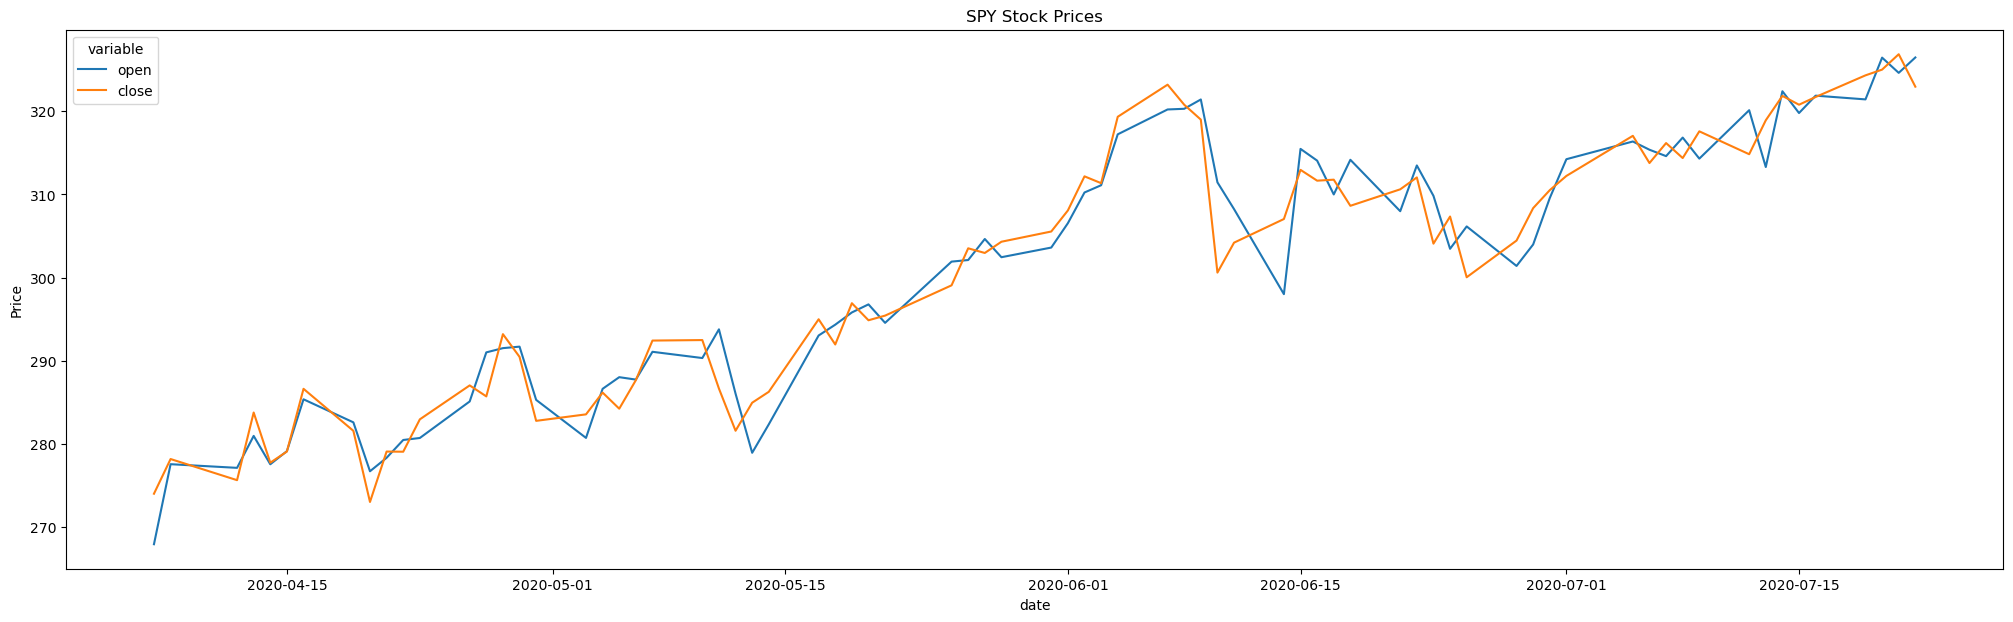

C:\Users\Cake\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cake\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cake\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Cake\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

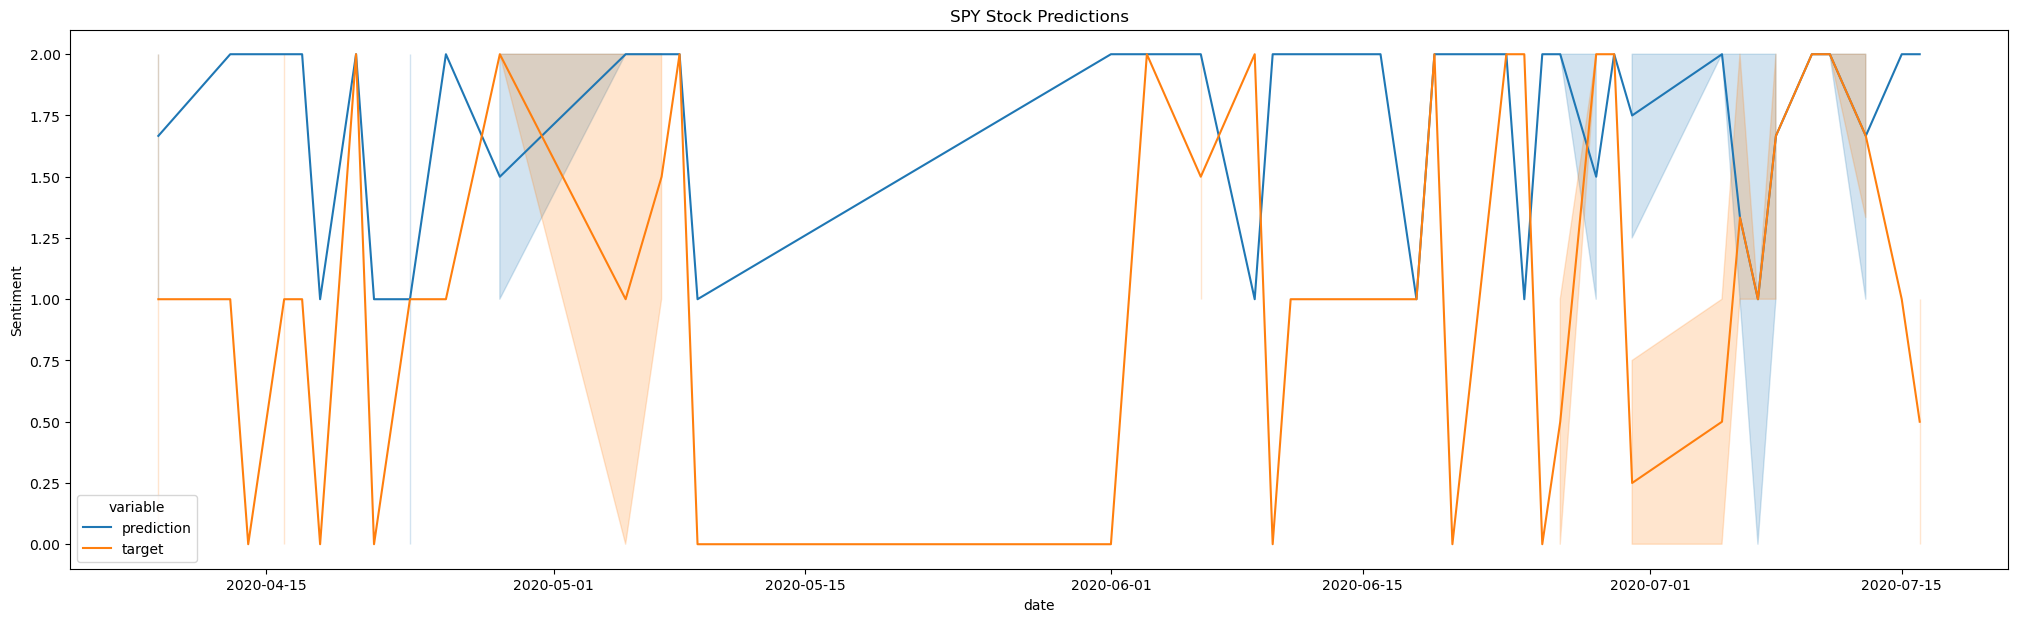

In [43]:
plt.figure (figsize = (25, 7))
sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(spy_df, ['date'])).set(title='SPY Stock Prices', ylabel='Price')
plt.show()

plt.figure (figsize = (25, 7))
# Sentiment values are {0: negative, 1: neutral, 2: positive}
sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(prediction_df, ['date'])).set(title='SPY Stock Predictions', ylabel='Sentiment')
plt.show()